In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
#Reading in Data
path = "/Users/jasonzhou/Documents/GuidedCapstone2"
os.chdir(path)
mercari_data = pd.read_csv("TrainMercari.csv")
mercari_data = mercari_data.rename(index=str, columns = {"name":"Name", "item_condition_id":"Condition",
                                                        "category_name":"Category", "brand_name":"Brand",
                                                        "price":"Price", "shipping":"Shipping",
                                                        "item_description":"Item Description"})
mercari_data = mercari_data.drop(columns=['train_id'])

In [4]:
#Quick Summary of the Data
mercari_data.describe()

,Condition,Price,Shipping
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.907426e+00,2.673614e+01,4.474091e-01
std,9.030750e-01,3.858335e+01,4.972267e-01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+01,0.000000e+00
50%,2.000000e+00,1.700000e+01,0.000000e+00
75%,3.000000e+00,2.900000e+01,1.000000e+00
max,5.000000e+00,2.009000e+03,1.000000e+00


In [5]:
#Fetching a preview of the dataset to make sure it was imported correctly without complications
mercari_data.head()

,Name,Condition,Category,Brand,Price,Shipping,Item Description
0,"- ""Litty"" Available in Multi Plus Sizes",1,Women/Tops & Blouses/Blouse,NaN,21,0,"- Blue , Distressed Top . Comes in 1x , 2x & 3..."
1,--- 2 pcs great universal earphone,1,"Electronics/TV, Audio & Surveillance/Headphones",NaN,10,1,Brand new best quality headphones for iphone6s...
2,' BARE WITH ME ' DOSE OF COLORS,1,Beauty/Makeup/Lips,Sephora,14,1,Liquid matte lipstick Beautiful nude color Bra...
3,' BERRY ME ' DOSE OF COLORS,1,Beauty/Makeup/Lips,Sephora,14,0,Matte liquid lipstick Brand new in box Dries t...
4,' BLIMEY LIMEY ' LOOSE GLITTER,2,Beauty/Makeup/Makeup Sets,NaN,5,1,COSMETIC LOOSE GLITTER! SPARKLES And SHINES!! ...


In [6]:
#Checking the data type of each column
mercari_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Name              1048575 non-null  object
 1   Condition         1048575 non-null  int64 
 2   Category          1044072 non-null  object
 3   Brand             601240 non-null   object
 4   Price             1048575 non-null  int64 
 5   Shipping          1048575 non-null  int64 
 6   Item Description  1048573 non-null  object
dtypes: int64(3), object(4)
memory usage: 64.0+ MB


In [7]:
#Checking to see how many missing values our dataset currently has.
mercari_data.isnull().mean()

Name                0.000000
Condition           0.000000
Category            0.004294
Brand               0.426612
Price               0.000000
Shipping            0.000000
Item Description    0.000002
dtype: float64

Seems like there are an abundance of missing values in the brand_name column, just a few in category_name,
and just a handful in item_description

In [8]:
#Now to find out exactly how many values are missing in each column
missing = pd.concat([mercari_data.isnull().sum(), 100 * mercari_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Brand,447335,42.661231
Category,4503,0.429440
Item Description,2,0.000191
Name,0,0.000000
Condition,0,0.000000
Price,0,0.000000
Shipping,0,0.000000


In [9]:
#Looking at the amount of listings with identical names
mercari_data['Name'].value_counts()

Bundle                                      1572
Reserved                                     325
Dress                                        312
Converse                                     303
BUNDLE                                       303
                                            ... 
FLASH SALE! WOODEN KITCHEN PLAY SET USED       1
10 dress bundle for willow wonka               1
Delta Zeta notebook set                        1
Classic 925 Silver Pandora Bracelet 16cm       1
Kay jeweler sterling silver ring               1
Name: Name, Length: 886108, dtype: int64

In [10]:
#Investigating how many total categories there are
mercari_data['Category'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    42262
Women/Tops & Blouses/T-Shirts                     32736
Beauty/Makeup/Face                                24267
Beauty/Makeup/Lips                                21136
Electronics/Video Games & Consoles/Games          18737
                                                  ...  
Handmade/Candles/Scrapbooking                         1
Handmade/Geekery/Housewares                           1
Vintage & Collectibles/Housewares/Towel               1
Home/Bath/Bathroom Shelves                            1
Kids/Diapering/Washcloths & Towels                    1
Name: Category, Length: 1258, dtype: int64

There appear to be 1258 categories total, with a large variety of items per category

In [11]:
# Checking even further to see if there are any listings with the same name and category
(mercari_data['Name'] + ' - ' + mercari_data['Category']).value_counts()

Lularoe TC leggings - Women/Athletic Apparel/Pants, Tights, Leggings                                     188
Converse - Women/Shoes/Fashion Sneakers                                                                  179
Coach wallet - Women/Women's Accessories/Wallets                                                         176
Michael Kors Wallet - Women/Women's Accessories/Wallets                                                  160
Miss Me Jeans - Women/Jeans/Boot Cut                                                                     158
                                                                                                        ... 
Michael Kors glasses case - Other/Other/Other                                                              1
Comics- Lobo - 4 Total- All NM condition - Vintage & Collectibles/Book/Comics                              1
Wipe wormer - Kids/Diapering/Wipes & Holders                                                               1
Lularoe XS Perfect 

Majority of listings have a unique name - category pairing

In [12]:
#Lets take a look at average price per category from highest to lowest: 

category_price_means = mercari_data.groupby('Category')['Price'].mean().sort_values(ascending=False)
print(category_price_means)

Category
Handmade/Bags and Purses/Clutch                           212.500000
Vintage & Collectibles/Antique/Furniture                  195.000000
Kids/Strollers/Standard                                   185.600000
Electronics/Computers & Tablets/Laptops & Netbooks        176.050633
Electronics/Computers & Tablets/Desktops & All-In-Ones    166.596330
                                                             ...    
Handmade/Candles/Sticker                                    5.000000
Kids/Diapering/Washcloths & Towels                          4.000000
Handmade/Children/Jewelry                                   3.333333
Vintage & Collectibles/Electronics/Game                     3.000000
Handmade/Accessories/Necktie                                3.000000
Name: Price, Length: 1258, dtype: float64


To preface, product Condition is given on a scale from 1-5, 1 being best condition, 5 being worst. Shipping is 1 
if fees are paid by sellers and 0 if paid by buyers. 
Here we can see the breakdown of conditions among listing, which is the most informative of the histograms. From 
the Price histogram all we can see is that the highest priced listing is around 2000, while the vast majority of 
listings fall between 0 and 200 dollars in price. The Shipping histogram then tells us that it's roughly half and 
half between sellers or buyers paying for shipping.

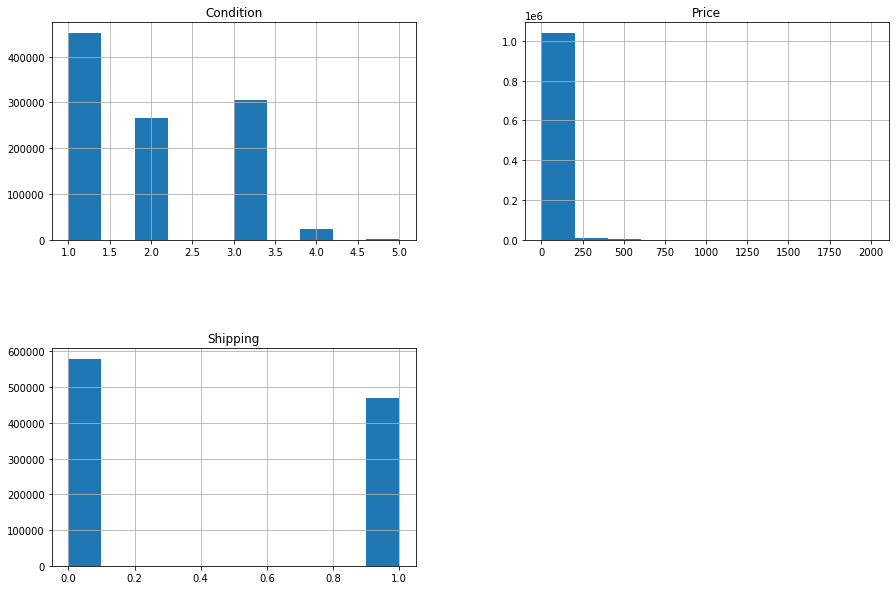

In [13]:
#Histograms of numeric features
mercari_data.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5);

Looks like we don't have any values that are invalid.

In [47]:
price_thresholds = [200, 500, 1000, 2000]
mercari_data['Price'][mercari_data['Price'] > 200].count()

7292

We need to decide what to do about the missing values in the Category and Brand columns. I believe it would be 
simplest to just fill in missing Category values with "Uncategorized" and missing "Brand" values with "Nonbranded".
Might as well take care of the 2 missing item descriptions too.

In [48]:
mercari_data['Brand'].fillna("Unbranded", inplace=True)
mercari_data['Category'].fillna("Uncategorized", inplace=True)
mercari_data['Item Description'].fillna("No Description", inplace=True)

In [49]:
# Verifying the data doesn't have NaN values anymore
missing = pd.concat([mercari_data.isnull().sum(), 100 * mercari_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Name,0,0.0
Condition,0,0.0
Category,0,0.0
Brand,0,0.0
Price,0,0.0
Shipping,0,0.0
Item Description,0,0.0


In [50]:
# Check for duplicate listings

duplicateRowsDF = mercari_data[mercari_data.duplicated()]
duplicateRowsDF

,Name,Condition,Category,Brand,Price,Shipping,Item Description
2403,(20) 10x13 daisy polymailer,1,Other/Office supplies/Shipping Supplies,Unbranded,6,1,- 20 pieces of 10x13 daisy poly mailer *** all...
2479,(20) Designer 10x13 Shipping Polymailers,1,Other/Office supplies/Shipping Supplies,Unbranded,6,1,â€¢â€¢â€¢â€¢Free Shippingâ€¢â€¢â€¢â€¢ â€¢â€¢Pi...
14458,100 - 10X13 PolyMailers,1,Other/Office supplies/Shipping Supplies,Unbranded,16,0,"100 - 10X13 Poly Mailers (100 min for pricing,..."
16375,10x iPhone chargers cables,1,Electronics/Cell Phones & Accessories/Cables &...,Unbranded,16,1,cool iPhone necessities kit!!! Includes: 10x c...
41682,3 IPhone 6/6S Tempered Glass Screen Prot,1,Electronics/Cell Phones & Accessories/Screen P...,Unbranded,10,1,â€¢ iPhone 6 or 6S Tempered Glass Protector â€...
46178,30 pcs Shipping Labels,1,Other/Office supplies/Shipping Supplies,Unbranded,6,1,These are Self Adhesive Shipping Stickers with...
60018,5ft braided aux cord auxiliary cable,1,Electronics/Cell Phones & Accessories/Cables &...,Unbranded,6,1,"Metal tips for added durability, plus 5ft so y..."
132075,Baltimore Ravens bracelet football NFL,1,Women/Jewelry/Bracelets,Unbranded,10,1,"Brand new free shipping PRICE IF FIRM , VERY F..."
198397,Breast and butt enhancer,1,Beauty/Skin Care/Body,Unbranded,8,1,Original 2 x[rm] 3x [rm] 4x [rm] Only let me k...
344390,FREE SHIP HIGH QUALITY SILICONE SPONGE,1,Beauty/Makeup/Brushes & Applicators,Unbranded,4,1,"Brand new sealed in bag! Fast shipping, US Sel..."


In [14]:
mercari_data.to_csv('MercariDataCleaned.csv')